In [1]:
import sys
import requests
import pandas as pd
from pathlib import Path
sys.path.append(str(Path().parent / "src"))
import avfetch
av_key = str(Path("av_key").read_text().strip())
frequency = "Weekly"
series = avfetch.series(av_key=av_key,outputsize='full',frequency=frequency)

In [2]:
tickers = [
    "ASML", "NVDA", "INTC", "AMD", "ARM",
    "AMZN", "AAPL", "NET", "MSFT",
    "JPM", "SPY", "GS", "MS", "UBS",
    "LMT", "RTX", "GE", "BA", "GD",
    "PEP", "KO",

    "BATS.LON", "SHEL.LON",
]

dest_currency = "EUR"

df = pd.DataFrame({t: series.equity(t) for t in tickers})

df = df.sort_index(ascending=False).dropna()
print(df)
processed_currencies = []

for c in df.columns:
    data = avfetch.search(av_key,c)
    data.index = data['1. symbol']
    currency = data['8. currency'][c]
    pairname = f'{currency}{dest_currency}'
    
    print(f"{c} is denominated in {currency}")
    if currency != dest_currency:
        print(f"Converting from {currency} to {dest_currency}")
        if currency not in processed_currencies:
            if currency == "GBX":
                currency = "GBP"
                df[c] = df[c]/100
                pairname = f'{currency}{dest_currency}'
            df[pairname] = series.fx(from_currency=currency,to_currency=dest_currency)
            df[f"{c}_{currency}_{dest_currency}"] = df[c].values * df[pairname].values
            processed_currencies.append(currency)
        else:
            df[f"{c}_{currency}_{dest_currency}"] = df[c].values * df[pairname]
    else:
        print(f"Already denominated in {dest_currency}, adding column '{c}_{dest_currency}' for consistency")
        df[f"{c}_{dest_currency}"] = df[c]
    print()

                 ASML      NVDA     INTC     AMD     ARM    AMZN      AAPL  \
2025-11-21   966.5700  178.8800  34.5000  203.78  131.57  220.69  271.4900   
2025-11-14  1006.9800  190.1700  35.5200  246.81  139.77  234.69  272.4100   
2025-11-07  1016.9600  188.1500  38.1300  233.54  152.38  244.41  268.2112   
2025-10-31  1059.2300  202.4900  39.9900  256.12  169.82  244.22  270.1093   
2025-10-24  1031.3048  186.2600  38.2800  252.92  170.68  224.21  262.5666   
...               ...       ...      ...     ...     ...     ...       ...   
2023-10-20   566.2432   41.3630  34.3383  101.81   47.87  125.17  171.0555   
2023-10-13   585.4238   45.4346  35.3708  105.09   50.78  129.79  176.9625   
2023-10-06   583.0909   45.7354  35.5872  107.24   54.08  127.96  175.6168   
2023-09-29   574.5987   43.4737  34.9578  102.82   53.52  127.12  169.4031   
2023-09-22   573.0760   41.5858  33.6107   96.20   51.32  129.12  172.9453   

               NET      MSFT       JPM  ...      UBS       LMT 

In [3]:
df[f"BTC_{dest_currency}"] = series.crypto("BTC",market=dest_currency)
df[f"ETH_{dest_currency}"] = series.crypto("ETH",market=dest_currency)

In [4]:
df = df.dropna(axis=1,how='all')

['ASML_USD_EUR', 'NVDA_USD_EUR', 'INTC_USD_EUR', 'AMD_USD_EUR', 'ARM_USD_EUR', 'AMZN_USD_EUR', 'AAPL_USD_EUR', 'NET_USD_EUR', 'MSFT_USD_EUR', 'JPM_USD_EUR', 'SPY_USD_EUR', 'GS_USD_EUR', 'MS_USD_EUR', 'UBS_USD_EUR', 'LMT_USD_EUR', 'RTX_USD_EUR', 'GE_USD_EUR', 'BA_USD_EUR', 'GD_USD_EUR', 'PEP_USD_EUR', 'KO_USD_EUR', 'BATS.LON_GBP_EUR', 'SHEL.LON_GBP_EUR']


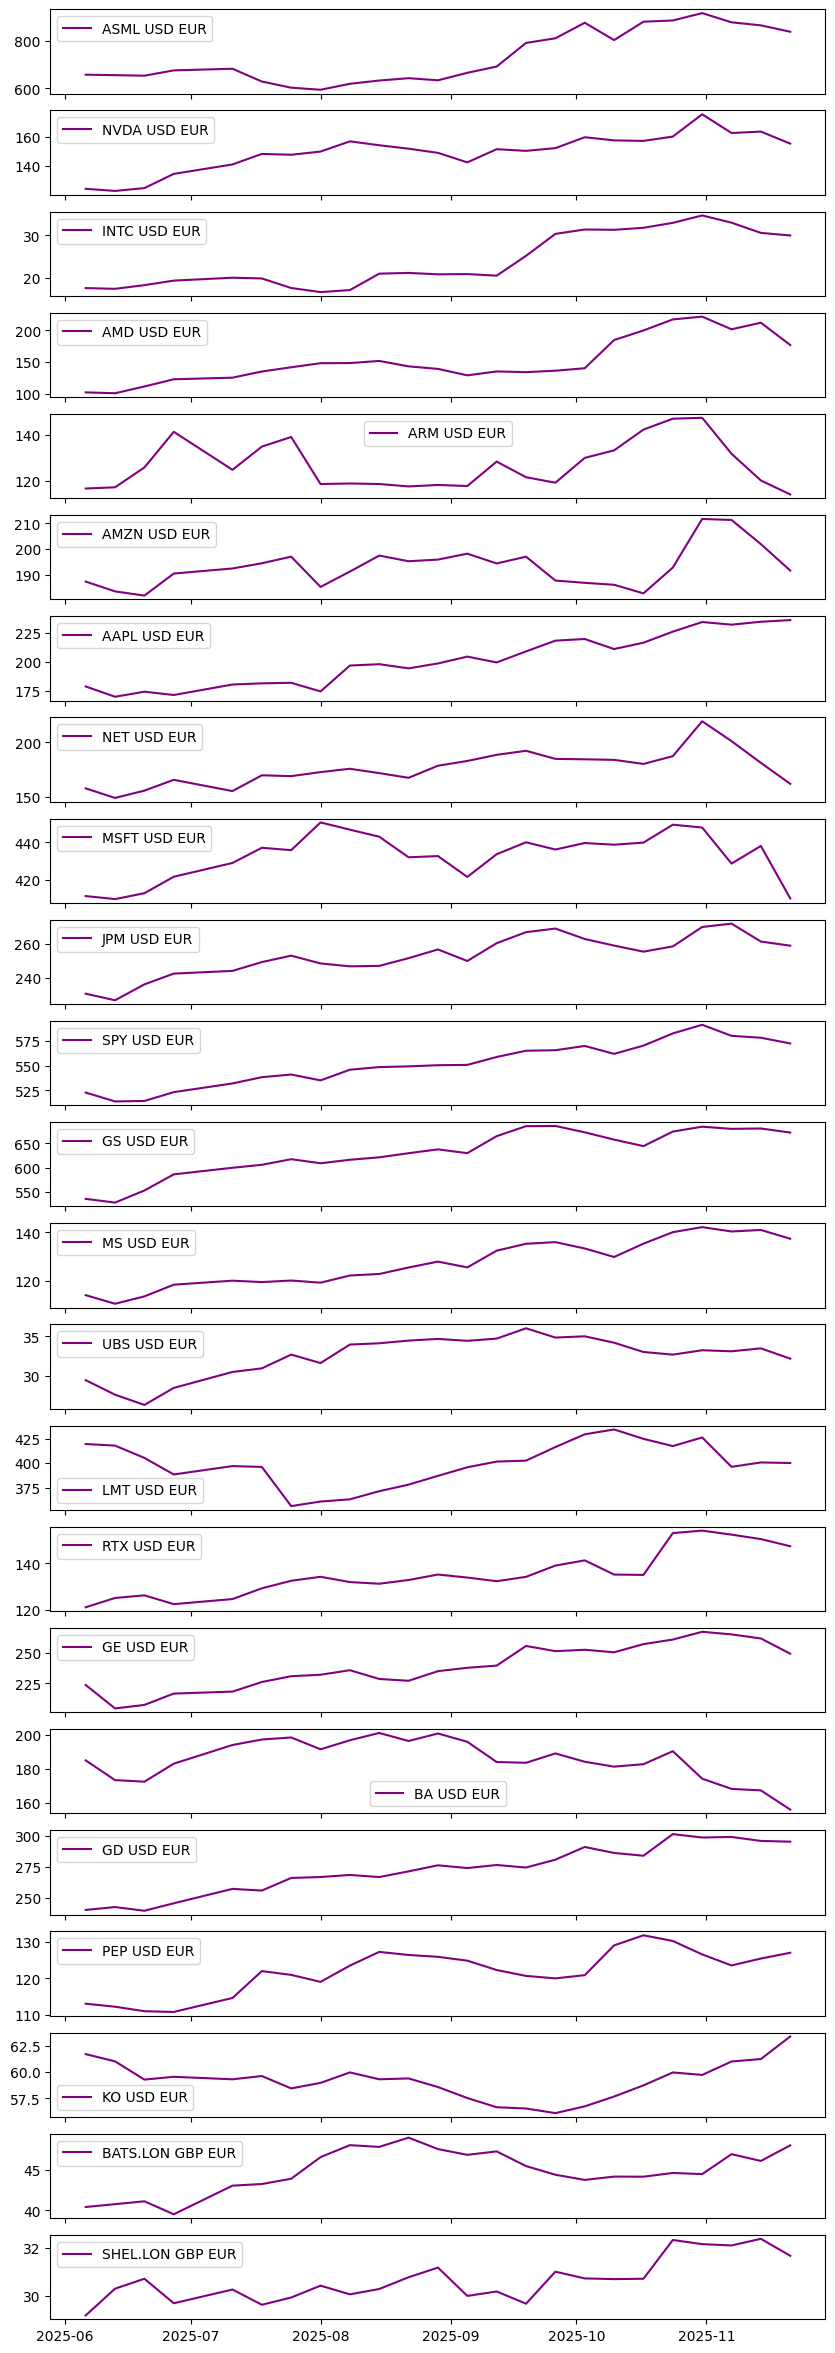

In [5]:
prices = df.sort_index(ascending=False).dropna(axis=0,how='any').filter(like=f'_{dest_currency}')
prices.index = pd.to_datetime(prices.index)
import plotters.PlotCols as plot
price_plot = plot(prices,figsize=(10,30))

In [6]:
returns = ((prices - prices.shift(-1)) / prices.shift(-1)).dropna()
average_returns = returns.mean()
if frequency == "Daily":
    Nt = 252
elif frequency == "Weekly":
    Nt = 52
elif frequency == "Monthly":
    Nt = 12
annualized_average_returns = average_returns * Nt
annualized_average_returns

ASML_USD_EUR        0.621785
NVDA_USD_EUR        0.548762
INTC_USD_EUR        1.389217
AMD_USD_EUR         1.456794
ARM_USD_EUR         0.075364
AMZN_USD_EUR        0.083385
AAPL_USD_EUR        0.668366
NET_USD_EUR         0.161388
MSFT_USD_EUR        0.006759
JPM_USD_EUR         0.271050
SPY_USD_EUR         0.209024
GS_USD_EUR          0.529812
MS_USD_EUR          0.434097
UBS_USD_EUR         0.234777
LMT_USD_EUR        -0.078432
RTX_USD_EUR         0.474807
GE_USD_EUR          0.274662
BA_USD_EUR         -0.342730
GD_USD_EUR          0.481219
PEP_USD_EUR         0.283341
KO_USD_EUR          0.066549
BATS.LON_GBP_EUR    0.418412
SHEL.LON_GBP_EUR    0.198509
dtype: float64

In [7]:
from pypfopt import expected_returns, EfficientSemivariance

es = EfficientSemivariance(annualized_average_returns, returns, frequency=Nt, weight_bounds=(0,1))
asml_idx = prices.columns.get_loc("SPY_USD_EUR")
es.add_constraint(lambda w, idx=asml_idx: w[idx] >= 0.20)
es.efficient_return(0.075)

weights = es.clean_weights()
print("Weights:")
for i,j in weights.items():
    print("  ",i,j)
print()
performance = es.portfolio_performance(verbose=True)

Weights:
   ASML_USD_EUR 0.07658
   NVDA_USD_EUR 0.0
   INTC_USD_EUR 0.0
   AMD_USD_EUR 0.0
   ARM_USD_EUR 0.0
   AMZN_USD_EUR 0.0
   AAPL_USD_EUR 0.07042
   NET_USD_EUR 0.0
   MSFT_USD_EUR 0.0
   JPM_USD_EUR 0.0
   SPY_USD_EUR 0.2
   GS_USD_EUR 0.0
   MS_USD_EUR 0.0
   UBS_USD_EUR 0.0
   LMT_USD_EUR 0.0
   RTX_USD_EUR 0.0
   GE_USD_EUR 0.0
   BA_USD_EUR 0.0
   GD_USD_EUR 0.19375
   PEP_USD_EUR 0.19292
   KO_USD_EUR 0.0
   BATS.LON_GBP_EUR 0.18651
   SHEL.LON_GBP_EUR 0.07982

Expected annual return: 37.8%
Annual semi-deviation: 0.8%
Sortino Ratio: 50.42


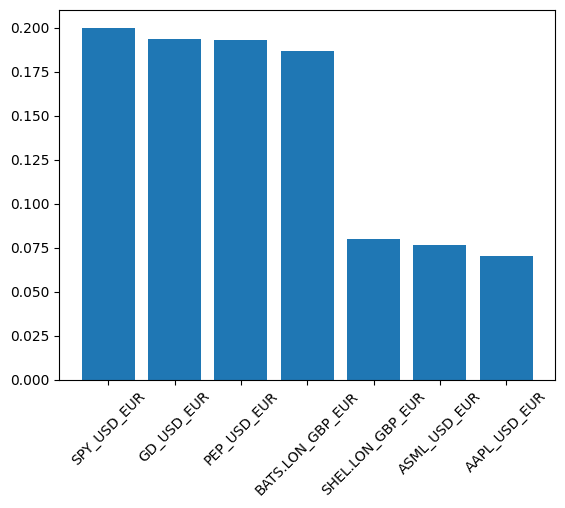

In [8]:
w = pd.Series(weights).sort_values(ascending=False)
w = w.where(w > 0).dropna()

import matplotlib.pyplot as plt
plt.bar(w.index, w.values)
plt.xticks(rotation=45)
plt.show()

In [9]:
spot = avfetch.spot(av_key)

P = 50_000
P_actual = 0
portfolio = {}

print(
    f"{"ticker": <10}",
    f"{"price": <10}",
    f"{"quantity": <10}",
    f"{"target": <10}",
    f"{"actual": <10}",
)

for i in w.index:
    target_amount = w[i] * P
    ticker = i.split('_')[0]
    source_currency = i.split('_')[1]
    if len(i.split('_')) < 3 and i.split('_')[0] == 'BTC':
        date, price = spot.fx("BTC",dest_currency)
        n_tokens = target_amount / price
        position = n_tokens * price
        P_actual += position
        print(
            f"{ticker: <10}", 
            f"{round(price,2): <10}", 
            f"{round(n_tokens,5): <10}", 
            f"{round(target_amount,2): <10}", 
            f"{round(position,2): <10}"
        )
        portfolio[ticker] = [price, n_tokens, position]
        pass
    else:
        destination_currency = i.split('_')[2]
        if source_currency != destination_currency:
            price_date, source_price = spot.equity(ticker)
            if source_currency == "GBP":
                source_price /= 100
            ex_date, exchange_rate = spot.fx(from_currency=source_currency,to_currency=destination_currency)
            dest_price = source_price * exchange_rate
            n_stock = int(target_amount // dest_price)
            position = dest_price * n_stock
            P_actual += position
            print(
                f"{ticker: <10}", 
                f"{round(source_price,2): <10}", 
                f"{int(n_stock): <10}", 
                f"{round(target_amount,2): <10}",
                f"{round(position,2): <10}"
            )
            portfolio[ticker] = [source_price, n_stock, position]
        else:
            price_date, price = spot.equity(ticker)
            n_stock = int(target_amount // price)
            position = price * n_stock
            P_actual += position
            print(
                f"{ticker: <10}", 
                f"{round(source_price,2): <10}", 
                f"{int(n_stock): <5}", 
                f"{round(target_amount,2): <10}",
                f"{round(position,2): <10}"
            )
            portfolio[ticker] = [source_price, n_stock, position]

print(f"\nPostition: {dest_currency} {round(P_actual,2)}")

ticker     price      quantity   target     actual    
SPY        659.03     17         10000.0    9725.77   
GD         340.34     32         9687.5     9454.37   
PEP        146.33     75         9646.0     9527.18   
BATS.LON   42.27      194        9325.5     9323.01   
SHEL.LON   27.85      126        3991.0     3989.5    
ASML       966.57     4          3829.0     3356.32   
AAPL       271.49     14         3521.0     3299.53   

Postition: EUR 48675.67


In [10]:
portfolio_df = pd.DataFrame(portfolio).T
portfolio_df.columns = ['source_price', 'quantity', f'{dest_currency}_position']
portfolio_df

,source_price,quantity,EUR_position
SPY,659.03,17.0,9725.767031
GD,340.34,32.0,9454.372928
PEP,146.33,75.0,9527.180475
BATS.LON,42.27,194.0,9323.012022
SHEL.LON,27.85,126.0,3989.495790
ASML,966.57,4.0,3356.317668
AAPL,271.49,14.0,3299.526566
